# 📊 STA211 - EDA & Prétraitement des Données <a id="1-introduction"></a>

Ce notebook réalise l’analyse exploratoire des données (EDA) et le prétraitement du dataset **Internet Advertisements** dans le cadre du module **STA211**. L’objectif est de prédire si une image est une publicité (`ad.`) ou non (`noad.`), en optimisant le **score F1** sur un jeu de test.

---

## 🔍 Objectifs :
- **Explorer les caractéristiques du dataset**
  - Dimensions des données (2459 lignes d’entraînement, 820 lignes de test, 1558 variables explicatives).
  - Types de variables : 3 quantitatives (géométrie des images) et 1555 binaires (mots-clés, URL, etc.).
  - Distribution des classes : analyse du déséquilibre (13.99% `ad.` vs 86.01% `noad.`).

- **Analyser la qualité des données**
  - Identifier et imputer les valeurs manquantes (MCAR, MAR, MNAR).
  - Détecter et traiter les valeurs aberrantes (outliers).
  - Vérifier la cohérence des données (types, valeurs inattendues).

- **Analyser les relations entre variables**
  - Distributions univariées (histogrammes, box-plots, QQ-plots).
  - Corrélations bivariées et multivariées (ACP, AFM, cartes de Kohonen).
  - Identification des mots-clés les plus discriminants pour la classe `ad.`.

- **Prétraiter les données pour la modélisation**
  - Encodage de la variable cible (`ad.`/`noad.` → 1/0).
  - Transformation des variables quantitatives (Yeo-Johnson, discrétisation).
  - Gestion du déséquilibre via SMOTE ou pondération des classes.
  - Séparation train/test stratifiée (80-20) pour validation.

---

## Définition des métadonnées du projet

**Objectif** : Définir les métadonnées du projet pour assurer la traçabilité et la reproductibilité du notebook. Ces informations identifient le projet, l’auteur, la version, et la période de réalisation.

**Contexte** : Dans le cadre du challenge *Internet Advertisements*, ces métadonnées servent à documenter le travail réalisé pour la classification binaire (`ad.` vs `noad.`) et à faciliter l’évaluation pédagogique.

**Méthodologie** : Les métadonnées sont stockées dans des variables globales et affichées pour confirmation. Une date dynamique est utilisée pour refléter le moment de l’exécution.

**Prochaines étapes** : Configurer l’environnement et charger les données (section suivante).

In [ ]:
## Définition des métadonnées du projet

from datetime import datetime
from pathlib import Path

# Métadonnées du projet
PROJECT_NAME = "Projet STA 211: Internet Advertisements Classification"
DATASET_NAME = "Internet Advertisements Dataset"
AUTHOR = "Abdoullatuf"
DATE = datetime.now().strftime("%Y-%m-%d")  # Date dynamique
VERSION = "1.0"

# Vérification des métadonnées
metadata = {
    "Projet": PROJECT_NAME,
    "Dataset": DATASET_NAME,
    "Auteur": AUTHOR,
    "Date": DATE,
    "Version": VERSION
}

# Affichage des informations
print("📋 Métadonnées du projet")
print("="*60)
for key, value in metadata.items():
    if not isinstance(value, str):
        raise TypeError(f"La métadonnée '{key}' doit être une chaîne de caractères, reçu {type(value)}")
    print(f"{key}: {value}")

# Sauvegarde des métadonnées dans un fichier (optionnel)
METADATA_DIR = Path("metadata")
METADATA_DIR.mkdir(exist_ok=True)
metadata_file = METADATA_DIR / f"metadata_v{VERSION}.txt"
with open(metadata_file, "w", encoding="utf-8") as f:
    for key, value in metadata.items():
        f.write(f"{key}: {value}\n")
print(f"✅ Métadonnées sauvegardées dans : {metadata_file}")

📋 Métadonnées du projet
Projet: Projet STA 211: Internet Advertisements Classification
Dataset: Internet Advertisements Dataset
Auteur: Abdoullatuf
Date: 2025-06-06
Version: 1.0
✅ Métadonnées sauvegardées dans : metadata/metadata_v1.0.txt


# Table des matières
1. [Introduction](#introduction)
2. [Configuration de l'environnement et imports](#configuration-environnement-imports)
    - 2.1 [Configuration de l'environnement](#configuration-environnement)
    - 2.2 [Import des bibliothèques](#import-des-bibliotheques)
    - 2.3 [Configuration des paramètres du projet](#configuration-parametres-projet)
3. [Chargement et aperçu des données](#chargement-et-apercu-des-donnees)
    - 3.1 [Chargement des jeux de données bruts](#chargement-des-jeux-de-donnees-bruts)
    - 3.2 [Inspection des colonnes et types](#inspection-des-colonnes-et-types)
    - 3.3 [Distribution de la variable cible](#distribution-variable-cible)
4. [Analyse exploratoire](#analyse-exploratoire)
    - 4.1 [Analyse des valeurs manquantes](#analyse-des-valeurs-manquantes)
    - 4.2 [Analyse statistique des variables quantitatives](#analyse-statistique-des-variables-quantitatives)
    - 4.3 [Distribution des variables binaires](#distribution-des-variables-binaires)
    - 4.4 [Analyse des corrélations](#analyse-des-correlations)
    - 4.5 [Visualisations exploratoires](#visualisations-exploratoires)
5. [Prétraitement avancé](#pretraitement-avance)
    - 5.1 [Transformation Yeo-Johnson sur X1, X2, X3](#transformation-yeo-johnson)
    - 5.2 [Détection et suppression des outliers](#detection-et-suppression-des-outliers)
    - 5.3 [Gestion des valeurs manquantes](#gestion-des-valeurs-manquantes)
        - 5.3.1 [Imputation de X4 par la médiane](#imputation-x4-mediane)
        - 5.3.2 [Préparation pour l'imputation multivariée](#preparation-imputation-multivariee)
    - 5.4 [Détection et traitement des variables collinéaires](#detection-et-traitement-des-variables-collineaires)
6. [Construction des datasets finaux](#construction-des-datasets-finaux)
    - 6.1 [Application du pipeline de prétraitement (KNN)](#pipeline-knn)
    - 6.2 [Application du pipeline de prétraitement (MICE)](#pipeline-mice)
    - 6.3 [Comparaison des méthodes d'imputation](#comparaison-methodes)
    - 6.4 [Génération des fichiers pour la modélisation](#generation-des-fichiers-pour-la-modelisation)
7. [Validation du prétraitement](#validation-pretraitement)
    - 7.1 [Vérification de la qualité des données](#verification-qualite)
    - 7.2 [Statistiques finales](#statistiques-finales)
8. [Conclusion](#conclusion)
9. [Annexes / Visualisations complémentaires](#annexes)

# 2. Configuration de l'environnement et imports <a id="2-configuration-de-lenvironnement-et-imports"></a>

## 2.1 Configuration de l'environnement <a id="21-configuration-de-lenvironnement"></a>

In [ ]:
## 2.1 Configuration de l'environnement <a id="configuration-environnement"></a>

# Installation des packages (décommenter si nécessaire)
# !pip install -q scikit-learn xgboost lightgbm imbalanced-learn umap-learn prince
!pip install -q scikit-learn imbalanced-learn umap-learn prince

import sys
import os
from pathlib import Path
from IPython.display import Markdown, display
import warnings

# Configuration des warnings et de pandas
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# 🔍 Détection de l'environnement
def detect_environment():
    try:
        import google.colab
        return "colab"
    except ImportError:
        return "local"

ENV = detect_environment()
print(f"🔧 Environnement détecté : {ENV}")

# 🚗 Montage de Google Drive si nécessaire
if ENV == "colab":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    print("✅ Google Drive monté avec succès")

# 📁 Définir les chemins selon l’environnement
if ENV == "colab":
    module_path = Path("/content/drive/MyDrive/projet_sta211/modules")
else:
    module_path = Path("G:/Mon Drive/projet_sta211/modules")

if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))
    print(f"✅ Module path ajouté : {module_path}")

# 📦 Chargement des chemins
try:
    if ENV == "colab":
        from config.paths_config import setup_project_paths
    else:
        from modules.config.paths_config import setup_project_paths

    paths = setup_project_paths()
    print("✅ Configuration des chemins réussie")
except ImportError as e:
    print(f"❌ Erreur : impossible d'importer setup_project_paths")
    raise

# 🔧 Ajout manuel OUTPUTS_DIR si absent
if "OUTPUTS_DIR" not in paths:
    paths["OUTPUTS_DIR"] = paths["ROOT_DIR"] / "outputs"

# 📋 Affichage Markdown des chemins
def display_paths():
    status_icons = {
        key: "✅" if Path(path).exists() else "❌"
        for key, path in paths.items()
    }
    paths_str = {k: str(v) for k, v in paths.items()}

    md = f"""
### 📂 **Chemins configurés pour le projet**

| Status | Nom du dossier      | Chemin                                        |
|--------|---------------------|-----------------------------------------------|
| {status_icons.get("ROOT_DIR", "?")} | `ROOT_DIR`          | `{paths_str.get("ROOT_DIR", "")}`             |
| {status_icons.get("MODULE_DIR", "?")} | `MODULE_DIR`        | `{paths_str.get("MODULE_DIR", "")}`           |
| {status_icons.get("RAW_DATA_DIR", "?")} | `RAW_DATA_DIR`      | `{paths_str.get("RAW_DATA_DIR", "")}`         |
| {status_icons.get("DATA_PROCESSED", "?")} | `DATA_PROCESSED`    | `{paths_str.get("DATA_PROCESSED", "")}`       |
| {status_icons.get("MODELS_DIR", "?")} | `MODELS_DIR`        | `{paths_str.get("MODELS_DIR", "")}`           |
| {status_icons.get("FIGURES_DIR", "?")} | `FIGURES_DIR`       | `{paths_str.get("FIGURES_DIR", "")}`          |
| {status_icons.get("OUTPUTS_DIR", "?")} | `OUTPUTS_DIR`       | `{paths_str.get("OUTPUTS_DIR", "")}`          |

**Légende :** ✅ = Existe | ❌ = N'existe pas
"""
    display(Markdown(md))

display_paths()

# 🔧 Infos système
print(f"\n🐍 Python version : {sys.version.split()[0]}")
print(f"📍 Working directory : {os.getcwd()}")

# 📌 Variables globales
ROOT_DIR = paths["ROOT_DIR"]
MODULE_DIR = paths["MODULE_DIR"]
RAW_DATA_DIR = paths["RAW_DATA_DIR"]
DATA_PROCESSED = paths["DATA_PROCESSED"]
MODELS_DIR = paths["MODELS_DIR"]
FIGURES_DIR = paths["FIGURES_DIR"]
OUTPUTS_DIR = paths["OUTPUTS_DIR"]



🔧 Environnement détecté : colab
Mounted at /content/drive
✅ Google Drive monté avec succès
✅ Module path ajouté : /content/drive/MyDrive/projet_sta211/modules
⚠️ Scikit-learn non disponible pour la configuration des pipelines
✅ Configuration des chemins réussie



### 📂 **Chemins configurés pour le projet**

| Status | Nom du dossier      | Chemin                                        |
|--------|---------------------|-----------------------------------------------|
| ✅ | `ROOT_DIR`          | `/content/drive/MyDrive/projet_sta211`             |
| ✅ | `MODULE_DIR`        | `/content/drive/MyDrive/projet_sta211/modules`           |
| ✅ | `RAW_DATA_DIR`      | `/content/drive/MyDrive/projet_sta211/data/raw`         |
| ✅ | `DATA_PROCESSED`    | `/content/drive/MyDrive/projet_sta211/data/processed`       |
| ✅ | `MODELS_DIR`        | `/content/drive/MyDrive/projet_sta211/models`           |
| ✅ | `FIGURES_DIR`       | `/content/drive/MyDrive/projet_sta211/outputs/figures`          |
| ✅ | `OUTPUTS_DIR`       | `/content/drive/MyDrive/projet_sta211/outputs`          |

**Légende :** ✅ = Existe | ❌ = N'existe pas



🐍 Python version : 3.11.13
📍 Working directory : /content


## 2.2 Import des bibliothèques

In [ ]:
## 2.2 Import des bibliothèques <a id="import-des-bibliotheques"></a>

# 📦 Modules standards
import sys
import os
import warnings
from pathlib import Path

# 🧮 Manipulation des données
import numpy as np
import pandas as pd

# 📊 Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Prétraitement & Modèles
from sklearn.experimental import enable_iterative_imputer  # ⬅️ Nécessaire pour IterativeImputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, mean_squared_error
from sklearn.model_selection import KFold

from typing import List, Dict, Optional



# 📈 Statistiques
from scipy.stats import pointbiserialr

# 🔁 Optionnel : UMAP
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("⚠️ UMAP non disponible. Certaines visualisations seront désactivées.")

# 🎲 Configuration globale
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.float_format", '{:.4f}'.format)
sns.set_style("whitegrid")
sns.set_palette("husl")

# Définition de RANDOM_STATE
if "RANDOM_STATE" not in globals():
    RANDOM_STATE = 42
    np.random.seed(RANDOM_STATE)

# 🔍 Vérification des modules critiques
print("\n🔍 Vérification des modules critiques :")
import sklearn  # Ajout explicite

required_modules = {
    "pandas": pd,
    "numpy": np,
    "scikit-learn": sklearn,
    "matplotlib": plt,
    "seaborn": sns
}

for name, alias in required_modules.items():
    try:
        _ = eval(alias) if isinstance(alias, str) else alias
        print(f"  ✅ {name}")
    except Exception:
        print(f"  ❌ {name} - problème lors de l'import")

# ⚙️ Résumé de configuration
print(f"\n⚙️ Configuration :")
print(f"  - Random State : {RANDOM_STATE}")
print(f"  - Style matplotlib : seaborn-whitegrid")
print(f"  - Palette seaborn : husl")
print(f"  - UMAP disponible : {UMAP_AVAILABLE}")
print(f"  - Python : {sys.version.split()[0]}")



🔍 Vérification des modules critiques :
  ✅ pandas
  ✅ numpy
  ✅ scikit-learn
  ✅ matplotlib
  ✅ seaborn

⚙️ Configuration :
  - Random State : 42
  - Style matplotlib : seaborn-whitegrid
  - Palette seaborn : husl
  - UMAP disponible : True
  - Python : 3.11.13


## 2.3 Configuration des paramètres du projet

In [ ]:
## 2.3 Configuration des paramètres du projet <a id="configuration-parametres-projet"></a>

# 📦 Import de la classe ProjectConfig et de la fonction de création
try:
    from config.project_config import ProjectConfig, create_config
except ImportError as e:
    print("❌ Erreur : impossible d'importer depuis 'config.project_config'")
    raise

# 🛠️ Création de la configuration avec les métadonnées + chemins
config = create_config(
    project_name=PROJECT_NAME,
    version=VERSION,
    author=AUTHOR,
    paths=paths
)

# 🎯 Ciblage de la métrique F1 pour le challenge
config.update("PROJECT_CONFIG.SCORING", "f1")
config.update("PROJECT_CONFIG.SCORING_METRICS", ["f1", "roc_auc", "precision", "recall"])
config.update("PROJECT_CONFIG.PRIMARY_METRIC", "f1")

# 👁️ Affichage de la configuration
config.display_config()

# 📌 Exemples d'accès à des valeurs clés
print("\n📌 Exemples d'accès à la configuration :")
print(f"  - Test size : {config.get('PROJECT_CONFIG.TEST_SIZE')}")
print(f"  - Méthode d'imputation X4 : {config.get('PROJECT_CONFIG.IMPUTATION_METHODS.X4')}")
print(f"  - Taille des figures : {config.get('VIZ_CONFIG.figure_size')}")

# 💾 Sauvegarde de la configuration dans le dossier 'config'
config_file = Path(paths["ROOT_DIR"]) / "config" / f"project_config_v{VERSION}.json"
config.save_config(config_file)

# 🌍 Rendre la configuration disponible globalement
PROJECT_CONFIG = config.PROJECT_CONFIG
COLUMN_CONFIG = config.COLUMN_CONFIG
VIZ_CONFIG = config.VIZ_CONFIG
MODEL_CONFIG = config.MODEL_CONFIG
PIPELINE_CONFIG = config.PIPELINE_CONFIG
SAVE_PATHS = config.SAVE_PATHS
F1_OPTIMIZATION = config.F1_OPTIMIZATION

print("\n✅ Configuration chargée et disponible globalement")


✅ Configuration mise à jour : PROJECT_CONFIG.SCORING = f1
✅ Configuration mise à jour : PROJECT_CONFIG.SCORING_METRICS = ['f1', 'roc_auc', 'precision', 'recall']
✅ Configuration mise à jour : PROJECT_CONFIG.PRIMARY_METRIC = f1
📋 Configuration du projet STA211
📊 Projet : Projet STA 211: Internet Advertisements Classification v1.0
👤 Auteur : Abdoullatuf
🎲 Random State : 42

🔧 Paramètres clés :
  - Test size : 20.0%
  - CV folds : 5
  - Métrique principale : f1 ⭐
  - Scoring CV : f1
  - Métriques suivies : f1, roc_auc, precision, recall
  - Seuil valeurs manquantes : 50.0%
  - Seuil corrélation : 0.95

💾 Méthodes d'imputation :
  - X4 : median
  - Autres : knn, mice

📌 Exemples d'accès à la configuration :
  - Test size : 0.2
  - Méthode d'imputation X4 : median
  - Taille des figures : (12, 8)
✅ Configuration sauvegardée dans : /content/drive/MyDrive/projet_sta211/config/project_config_v1.0.json

✅ Configuration chargée et disponible globalement


# 3. Chargement et aperçu des données <a id="chargement-et-apercu-des-donnees"></a>
## 3.1 Chargement des jeux de données bruts <a id="chargement-des-jeux-de-donnees-bruts"></a>

**Objectif** : Charger les datasets d’entraînement (`data_train.csv`) et de test (`data_test.csv`), vérifier leur structure, et préparer la variable cible pour l’analyse exploratoire.

**Théorie** : Un chargement correct des données est essentiel pour garantir la reproductibilité et la validité des analyses. La vérification des dimensions et des types de données permet de détecter les erreurs tôt dans le processus.

**Méthodologie** : Nous utilisons la fonction `load_data` pour charger les fichiers CSV, nettoyons les données (suppression des guillemets, gestion des doublons), encodons la variable cible (`ad.` → 1, `noad.` → 0), et affichons un résumé des dimensions et types.

**Prochaines étapes** : Inspecter les colonnes et types (section 3.2) et analyser la distribution de la variable cible (section 3.3).

In [ ]:
## 3.1 Chargement des jeux de données bruts <a id="chargement-des-jeux-de-donnees-bruts"></a>

from preprocessing.data_loader import load_data
#from modules.preprocessing.data_loader import load_data  # en local si jamais ne fonctionne pas, décoche ce si.


from pathlib import Path

# 📁 Vérification de l’existence du dossier RAW_DATA_DIR
if 'RAW_DATA_DIR' not in globals():
    raise NameError("❌ RAW_DATA_DIR n’est pas défini. Vérifiez la configuration dans la section 2.1.")

raw_data_dir = Path(RAW_DATA_DIR)
if not raw_data_dir.exists():
    raise FileNotFoundError(f"❌ Dossier RAW_DATA_DIR introuvable : {raw_data_dir}")

# 📂 Chargement des fichiers CSV
print("📂 Chargement des jeux de données...")

df_study = load_data(
    file_path="data_train.csv",
    require_outcome=True,
    display_info=True,
    raw_data_dir=RAW_DATA_DIR,
    encode_target=True
)

df_eval = load_data(
    file_path="data_test.csv",
    require_outcome=False,
    display_info=True,
    raw_data_dir=RAW_DATA_DIR,
    encode_target=False
)

# 🏷️ Renommer 'outcome' en 'y' si nécessaire
if 'outcome' in df_study.columns:
    df_study = df_study.rename(columns={'outcome': 'y'})
    print("✅ Colonne 'outcome' renommée en 'y'")
elif 'y' not in df_study.columns:
    raise ValueError("❌ Colonne 'y' ou 'outcome' manquante dans df_study")

# 🔢 Vérification des dimensions attendues
expected_train_shape = (2459, 1559)
expected_test_shape = (820, 1558)

if df_study.shape != expected_train_shape:
    print(f"⚠️ Dimensions inattendues pour df_study : {df_study.shape} (attendu : {expected_train_shape})")
if df_eval.shape != expected_test_shape:
    print(f"⚠️ Dimensions inattendues pour df_eval : {df_eval.shape} (attendu : {expected_test_shape})")

# 🔍 Vérification de la variable cible
print("\n🔎 Valeurs uniques de y :", df_study['y'].unique())
print("🔎 Type de y :", df_study['y'].dtype)

# 📊 Résumé
print(f"\n📊 Résumé :")
print(f"  - Fichier d’étude     : {df_study.shape}")
print(f"  - Fichier d’évaluation : {df_eval.shape}")
print("\n✅ Chargement terminé avec succès !")


📂 Chargement des jeux de données...
✅ Colonne 'outcome' encodée en numérique (ad. → 1, noad. → 0)

✅ Fichier chargé : /content/drive/MyDrive/projet_sta211/data/raw/data_train.csv
🔢 Dimensions : (2459, 1559)
📋 Infos colonnes :
<class 'pandas.core.frame.DataFrame'>
Index: 2459 entries, 1 to 2459
Columns: 1559 entries, X1 to outcome
dtypes: float64(4), int64(1555)
memory usage: 29.3 MB

🔎 Premières lignes :


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X188,X189,X190,X191,X192,X193,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X233,X234,X235,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X268,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X289,X290,X291,X292,X293,X294,X295,X296,X297,X298,X299,X300,X301,X302,X303,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X330,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X381,X382,X383,X384,X385,X386,X387,X388,X389,X390,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400,X401,X402,X403,X404,X405,X406,X407,X408,X409,X410,X411,X412,X413,X414,X415,X416,X417,X418,X419,X420,X421,X422,X423,X424,X425,X426,X427,X428,X429,X430,X431,X432,X433,X434,X435,X436,X437,X438,X439,X440,X441,X442,X443,X444,X445,X446,X447,X448,X449,X450,X451,X452,X453,X454,X455,X456,X457,X458,X459,X460,X461,X462,X463,X464,X465,X466,X467,X468,X469,X470,X471,X472,X473,X474,X475,X476,X477,X478,X479,X480,X481,X482,X483,X484,X485,X486,X487,X488,X489,X490,X491,X492,X493,X494,X495,X496,X497,X498,X499,X500,X501,X502,X503,X504,X505,X506,X507,X508,X509,X510,X511,X512,X513,X514,X515,X516,X517,X518,X519,X520,X521,X522,X523,X524,X525,X526,X527,X528,X529,X530,X531,X532,X533,X534,X535,X536,X537,X538,X539,X540,X541,X542,X543,X544,X545,X546,X547,X548,X549,X550,X551,X552,X553,X554,X555,X556,X557,X558,X559,X560,X561,X562,X563,X564,X565,X566,X567,X568,X569,X570,X571,X572,X573,X574,X575,X576,X577,X578,X579,X580,X581,X582,X583,X584,X585,X586,X587,X588,X589,X590,X591,X592,X593,X594,X595,X596,X597,X598,X599,X600,X601,X602,X603,X604,X605,X606,X607,X608,X609,X610,X611,X612,X613,X614,X615,X616,X617,X618,X619,X620,X621,X622,X623,X624,X625,X626,X627,X628,X629,X630,X631,X632,X633,X634,X635,X636,X637,X638,X639,X640,X641,X642,X643,X644,X645,X646,X647,X648,X649,X650,X651,X652,X653,X654,X655,X656,X657,X658,X659,X660,X661,X662,X663,X664,X665,X666,X667,X668,X669,X670,X671,X672,X673,X674,X675,X676,X677,X678,X679,X680,X681,X682,X683,X684,X685,X686,X687,X688,X689,X690,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700,X701,X702,X703,X704,X705,X706,X707,X708,X709,X710,X711,X712,X713,X714,X715,X716,X717,X718,X719,X720,X721,X722,X723,X724,X725,X726,X727,X728,X729,X730,X731,X732,X733,X734,X735,X736,X737,X738,X739,X740,X741,X742,X743,X744,X745,X746,X747,X748,X749,X750,X751,X752,X753,X754,X755,X756,X757,X758,X759,X760,X761,X762,X763,X764,X765,X766,X767,X768,X769,X770,X771,X772,X773,X774,X775,X776,X777,X778,X779,X780,X781,X782,X783,X784,X785,X786,X787,X788,X789,X790,X791,X792,X793,X794,X795,X796,X797,X798,X799,X800,X801,X802,X803,X804,X805,X806,X807,X808,X809,X810,X811,X812,X813,X814,X815,X816,X817,X818,X819,X820,X821,X8


✅ Fichier chargé : /content/drive/MyDrive/projet_sta211/data/raw/data_test.csv
🔢 Dimensions : (820, 1558)
📋 Infos colonnes :
<class 'pandas.core.frame.DataFrame'>
Index: 820 entries, 2460 to 3279
Columns: 1558 entries, X1 to X1558
dtypes: float64(4), int64(1554)
memory usage: 9.8 MB

🔎 Premières lignes :


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X188,X189,X190,X191,X192,X193,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X233,X234,X235,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X268,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X289,X290,X291,X292,X293,X294,X295,X296,X297,X298,X299,X300,X301,X302,X303,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X330,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X381,X382,X383,X384,X385,X386,X387,X388,X389,X390,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400,X401,X402,X403,X404,X405,X406,X407,X408,X409,X410,X411,X412,X413,X414,X415,X416,X417,X418,X419,X420,X421,X422,X423,X424,X425,X426,X427,X428,X429,X430,X431,X432,X433,X434,X435,X436,X437,X438,X439,X440,X441,X442,X443,X444,X445,X446,X447,X448,X449,X450,X451,X452,X453,X454,X455,X456,X457,X458,X459,X460,X461,X462,X463,X464,X465,X466,X467,X468,X469,X470,X471,X472,X473,X474,X475,X476,X477,X478,X479,X480,X481,X482,X483,X484,X485,X486,X487,X488,X489,X490,X491,X492,X493,X494,X495,X496,X497,X498,X499,X500,X501,X502,X503,X504,X505,X506,X507,X508,X509,X510,X511,X512,X513,X514,X515,X516,X517,X518,X519,X520,X521,X522,X523,X524,X525,X526,X527,X528,X529,X530,X531,X532,X533,X534,X535,X536,X537,X538,X539,X540,X541,X542,X543,X544,X545,X546,X547,X548,X549,X550,X551,X552,X553,X554,X555,X556,X557,X558,X559,X560,X561,X562,X563,X564,X565,X566,X567,X568,X569,X570,X571,X572,X573,X574,X575,X576,X577,X578,X579,X580,X581,X582,X583,X584,X585,X586,X587,X588,X589,X590,X591,X592,X593,X594,X595,X596,X597,X598,X599,X600,X601,X602,X603,X604,X605,X606,X607,X608,X609,X610,X611,X612,X613,X614,X615,X616,X617,X618,X619,X620,X621,X622,X623,X624,X625,X626,X627,X628,X629,X630,X631,X632,X633,X634,X635,X636,X637,X638,X639,X640,X641,X642,X643,X644,X645,X646,X647,X648,X649,X650,X651,X652,X653,X654,X655,X656,X657,X658,X659,X660,X661,X662,X663,X664,X665,X666,X667,X668,X669,X670,X671,X672,X673,X674,X675,X676,X677,X678,X679,X680,X681,X682,X683,X684,X685,X686,X687,X688,X689,X690,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700,X701,X702,X703,X704,X705,X706,X707,X708,X709,X710,X711,X712,X713,X714,X715,X716,X717,X718,X719,X720,X721,X722,X723,X724,X725,X726,X727,X728,X729,X730,X731,X732,X733,X734,X735,X736,X737,X738,X739,X740,X741,X742,X743,X744,X745,X746,X747,X748,X749,X750,X751,X752,X753,X754,X755,X756,X757,X758,X759,X760,X761,X762,X763,X764,X765,X766,X767,X768,X769,X770,X771,X772,X773,X774,X775,X776,X777,X778,X779,X780,X781,X782,X783,X784,X785,X786,X787,X788,X789,X790,X791,X792,X793,X794,X795,X796,X797,X798,X799,X800,X801,X802,X803,X804,X805,X806,X807,X808,X809,X810,X811,X812,X813,X814,X815,X816,X817,X818,X819,X820,X821,X8

✅ Colonne 'outcome' renommée en 'y'

🔎 Valeurs uniques de y : [1 0]
🔎 Type de y : int64

📊 Résumé :
  - Fichier d’étude     : (2459, 1559)
  - Fichier d’évaluation : (820, 1558)

✅ Chargement terminé avec succès !


## 3.2 Inspection des colonnes et types

In [ ]:
## 3.2 Inspection des colonnes et types <a id="inspection-des-colonnes-et-types"></a>

print("🔍 Inspection des types de données")
print("=" * 60)

# 🔎 Résumé des types dans df_study
print("\n📊 Types de données dans df_study :")
type_counts = df_study.dtypes.value_counts()
for dtype, count in type_counts.items():
    print(f"  - {dtype}: {count} colonnes")

# 📌 Identification des colonnes par type
continuous_cols = df_study.select_dtypes(include=['float64']).columns.tolist()
int_cols = df_study.select_dtypes(include=['int64']).columns.tolist()
categorical_cols = df_study.select_dtypes(include=['object']).columns.tolist()

# 🔁 Vérification binaire réelle parmi les colonnes int
binary_cols = []
non_binary_cols = []

for col in int_cols:
    unique_vals = df_study[col].dropna().unique()
    if len(unique_vals) == 2 and set(unique_vals).issubset({0, 1}):
        binary_cols.append(col)
    else:
        non_binary_cols.append(col)

print(f"\n📈 Colonnes continues : {len(continuous_cols)}")
print(f"🔢 Colonnes binaires : {len(binary_cols)}")
print(f"📦 Colonnes catégorielles : {len(categorical_cols)}")

if non_binary_cols:
    print(f"⚠️ Colonnes int64 non binaires détectées (extrait) : {non_binary_cols[:5]}")

# 🎯 Variable cible 'y'
if 'y' in df_study.columns:
    print("\n🎯 Variable cible 'y' :")
    print(f"  - Type : {df_study['y'].dtype}")
    print(f"  - Valeurs uniques : {sorted(df_study['y'].dropna().unique())}")
    print(f"  - Distribution :\n{df_study['y'].value_counts().sort_index()}")
else:
    print("❌ La colonne cible 'y' est manquante")

# 🔄 Comparaison avec df_eval
print("\n🔄 Comparaison avec df_eval :")
eval_type_counts = df_eval.dtypes.value_counts()
for dtype, count in eval_type_counts.items():
    print(f"  - {dtype}: {count} colonnes")

# ⚖️ Vérification des types entre df_study et df_eval
print("\n🔍 Vérification de la cohérence des types entre fichiers :")
type_mismatches = [
    (col, df_study[col].dtype, df_eval[col].dtype)
    for col in df_eval.columns if col in df_study.columns and df_study[col].dtype != df_eval[col].dtype
]

if type_mismatches:
    print("⚠️ Incohérences de type détectées :")
    for col, t1, t2 in type_mismatches:
        print(f"  - {col}: {t1} (étude) vs {t2} (éval)")
else:
    print("✅ Types cohérents entre df_study et df_eval")

# 💾 Mise à jour de la configuration
print("\n💾 Mise à jour de la configuration...")
config.update("COLUMN_CONFIG.CONTINUOUS_COLS", continuous_cols)
config.update("COLUMN_CONFIG.BINARY_COLS", binary_cols)
config.update("COLUMN_CONFIG.CATEGORICAL_COLS", categorical_cols)

# 📋 Résumé final
print("\n📊 Résumé des colonnes (hors 'y') :")
print(f"  - Colonnes continues   : {len(continuous_cols)}")
print(f"  - Colonnes binaires    : {len(binary_cols)}")
print(f"  - Colonnes catégorielles : {len(categorical_cols)}")
print(f"  - Total features (hors cible) : {df_study.shape[1] - 1}")


🔍 Inspection des types de données

📊 Types de données dans df_study :
  - int64: 1555 colonnes
  - float64: 4 colonnes

📈 Colonnes continues : 4
🔢 Colonnes binaires : 1555
📦 Colonnes catégorielles : 0

🎯 Variable cible 'y' :
  - Type : int64
  - Valeurs uniques : [np.int64(0), np.int64(1)]
  - Distribution :
y
0    2115
1     344
Name: count, dtype: int64

🔄 Comparaison avec df_eval :
  - int64: 1554 colonnes
  - float64: 4 colonnes

🔍 Vérification de la cohérence des types entre fichiers :
✅ Types cohérents entre df_study et df_eval

💾 Mise à jour de la configuration...
✅ Configuration mise à jour : COLUMN_CONFIG.CONTINUOUS_COLS = ['X1', 'X2', 'X3', 'X4']
✅ Configuration mise à jour : COLUMN_CONFIG.BINARY_COLS = ['X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', '

## 3.3 Distribution de la variable cible <a id="distribution-variable-cible"></a>


🎯 Analyse de la distribution de la variable cible

📊 Distribution de la variable cible (y) :
  - Classe 0 (noad.)    : 2,115 (86.0%)
  - Classe 1 (ad.)      : 344 (14.0%)

📈 Ratio de déséquilibre : 6.15:1
   → Pour chaque publicité, il y a 6.1 non-publicités


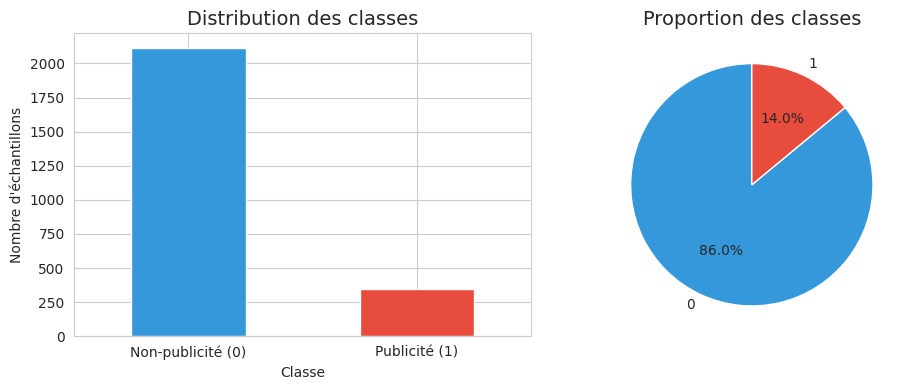


💡 Implications pour la modélisation :
  - Dataset fortement déséquilibré (6.1:1)
  - Stratégies recommandées :
    • Utiliser stratify=True lors du train/test split
    • Appliquer SMOTE ou class_weight='balanced'
    • Optimiser pour F1-score (métrique du challenge)
    • Envisager un stacking ou un modèle robuste aux déséquilibres

📊 F1-score baseline (prédire toujours 'ad.') : 0.245
   → Les modèles devront dépasser ce seuil pour être utiles


In [ ]:
## 3.3 Distribution de la variable cible <a id="distribution-variable-cible"></a>

print("\n🎯 Analyse de la distribution de la variable cible")
print("=" * 60)

# Vérification de la présence de 'y'
if 'y' not in df_study.columns:
    raise ValueError("❌ Colonne cible 'y' introuvable dans df_study")

# Distribution brute et en %
target_counts = df_study['y'].value_counts().sort_index()
target_pct = df_study['y'].value_counts(normalize=True).sort_index() * 100

# Affichage des proportions
print("\n📊 Distribution de la variable cible (y) :")
for label in target_counts.index:
    label_str = "Classe 1 (ad.)" if label == 1 else "Classe 0 (noad.)"
    print(f"  - {label_str:<20}: {target_counts[label]:,} ({target_pct[label]:.1f}%)")

# Ratio de déséquilibre
imbalance_ratio = target_counts[0] / target_counts[1]
print(f"\n📈 Ratio de déséquilibre : {imbalance_ratio:.2f}:1")
print(f"   → Pour chaque publicité, il y a {imbalance_ratio:.1f} non-publicités")

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Bar plot
target_counts.plot(kind='bar', ax=ax1, color=['#3498db', '#e74c3c'])
ax1.set_title('Distribution des classes', fontsize=14)
ax1.set_xlabel('Classe')
ax1.set_ylabel('Nombre d\'échantillons')
ax1.set_xticklabels(['Non-publicité (0)', 'Publicité (1)'], rotation=0)

# Pie chart
target_pct.plot(kind='pie', ax=ax2, colors=['#3498db', '#e74c3c'],
                autopct='%1.1f%%', startangle=90)
ax2.set_title('Proportion des classes', fontsize=14)
ax2.set_ylabel('')

plt.tight_layout()

# Sauvegarde sécurisée dans un sous-dossier
eda_dir = FIGURES_DIR / 'eda'
eda_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(eda_dir / 'target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Impact pour la modélisation
print("\n💡 Implications pour la modélisation :")
print(f"  - Dataset fortement déséquilibré ({imbalance_ratio:.1f}:1)")
print("  - Stratégies recommandées :")
print("    • Utiliser stratify=True lors du train/test split")
print("    • Appliquer SMOTE ou class_weight='balanced'")
print("    • Optimiser pour F1-score (métrique du challenge)")
print("    • Envisager un stacking ou un modèle robuste aux déséquilibres")

# Calcul du F1-score baseline
p = target_pct[1] / 100  # Précision et recall identiques si on prédit toujours 1
baseline_f1 = 2 * p / (1 + p)
print(f"\n📊 F1-score baseline (prédire toujours 'ad.') : {baseline_f1:.3f}")
print("   → Les modèles devront dépasser ce seuil pour être utiles")


# 4. Analyse exploratoire <a id="analyse-exploratoire"></a>
## 4.1 Analyse des valeurs manquantes <a id="analyse-des-valeurs-manquantes"></a>

### 4.1 Analyse des valeurs manquantes <a id="analyse-des-valeurs-manquantes"></a>

**Objectif** : Identifier les valeurs manquantes dans le dataset d’entraînement et d’évaluation, analyser leur pattern (MCAR, MAR, MNAR), et proposer une stratégie d’imputation adaptée.

**Théorie** : Les valeurs manquantes peuvent être MCAR (aléatoires), MAR (liées à d’autres variables observées), ou MNAR (liées à la variable elle-même). Une corrélation significative entre l’indicateur de valeurs manquantes et la variable cible suggère un pattern MAR, nécessitant une imputation sophistiquée (k-NN, MICE).

**Méthodologie** : Nous calculons le pourcentage de valeurs manquantes par colonne, visualisons leur pattern via une heatmap, et analysons la corrélation entre les indicateurs de valeurs manquantes et la variable cible encodée. Une stratégie d’imputation est proposée en fonction des résultats.

**Prochaines étapes** : Si un pattern MAR est confirmé, préparer une imputation multivariée (section 5.3). Vérifier l’impact des imputations sur les performances des modèles.

🔍 Analyse des valeurs manquantes

📊 Analyse globale des valeurs manquantes :
Total missing       : 2037 (0.05%)
Colonnes affectées  : 4 (haut: 0, moyen: 3, bas: 1)
Top 5 colonnes manquantes :
X3   27.6129
X1   27.4095
X2   27.3688
X4    0.4473
dtype: float64

📈 Détail des valeurs manquantes pour les variables continues :
  - X1: 674 (27.41%)
  - X2: 673 (27.37%)
  - X3: 679 (27.61%)
  - X4: 11 (0.45%)


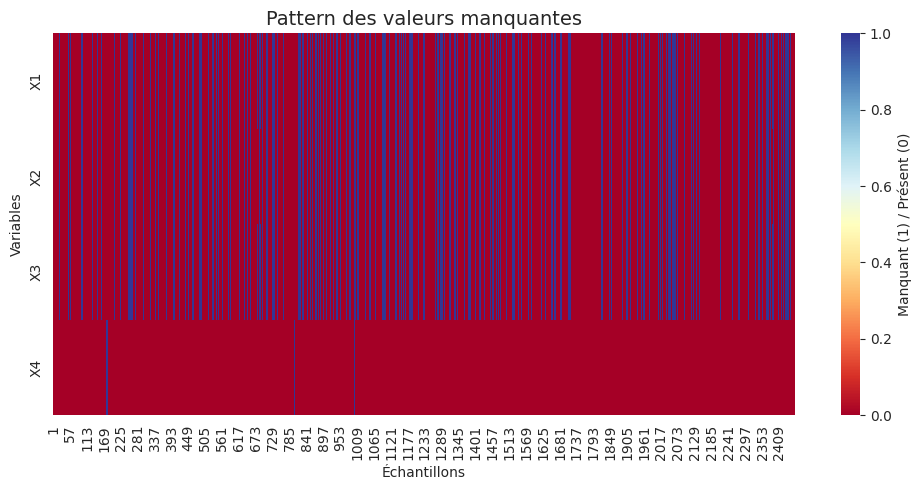


🔍 Analyse du type de valeurs manquantes (MAR vs MCAR) :
  - X1: corrélation avec y = -0.101
    → Potentiellement MAR (Missing At Random)
  - X2: corrélation avec y = -0.100
    → Potentiellement MAR (Missing At Random)
  - X3: corrélation avec y = -0.102
    → Potentiellement MAR (Missing At Random)
  - X4: corrélation avec y = 0.061
    → Potentiellement MCAR (Missing Completely At Random)

📊 Analyse des valeurs manquantes dans le fichier d'évaluation :
Total missing       : 692 (0.05%)
Colonnes affectées  : 4 (haut: 0, moyen: 3, bas: 1)
Top 5 colonnes manquantes :
X3   28.1707
X1   27.9268
X2   27.8049
X4    0.4878
dtype: float64

🔄 Comparaison des patterns de valeurs manquantes :
  - Fichier d'étude : 0.05% manquant
  - Fichier d'évaluation : 0.05% manquant

💡 Stratégie d'imputation recommandée :
  - X4 (0.4% manquant) : Imputation par la médiane
  - X1, X2, X3 (variables continues) : KNN ou MICE (imputation multivariée)


In [ ]:
# 4. Analyse exploratoire <a id="analyse-exploratoire"></a>
## 4.1 Analyse des valeurs manquantes <a id="analyse-des-valeurs-manquantes"></a>

print("🔍 Analyse des valeurs manquantes")
print("="*60)

# Utilisation de la fonction du module
from preprocessing.missing_values import (
    analyze_missing_values,
    handle_missing_values,
    find_optimal_k
)



print("\n📊 Analyse globale des valeurs manquantes :")
missing_stats = analyze_missing_values(df_study)

# Analyse détaillée pour les colonnes continues
print("\n📈 Détail des valeurs manquantes pour les variables continues :")
for col in continuous_cols:
    missing_count = df_study[col].isnull().sum()
    missing_pct = (missing_count / len(df_study)) * 100
    print(f"  - {col}: {missing_count} ({missing_pct:.2f}%)")

# Visualisation des patterns de valeurs manquantes
if missing_stats['total_missing'] > 0:
    # Heatmap des valeurs manquantes pour les colonnes avec des NaN
    cols_with_missing = [col for col in df_study.columns if df_study[col].isnull().sum() > 0]

    if len(cols_with_missing) > 0:
        plt.figure(figsize=(10, 5))

        # Créer une matrice binaire des valeurs manquantes
        missing_matrix = df_study[cols_with_missing].isnull().astype(int)

        # Heatmap
        sns.heatmap(missing_matrix.T, cmap='RdYlBu', cbar_kws={'label': 'Manquant (1) / Présent (0)'})
        plt.title('Pattern des valeurs manquantes', fontsize=14)
        plt.xlabel('Échantillons')
        plt.ylabel('Variables')
        plt.tight_layout()
        plt.savefig(FIGURES_DIR / 'eda' / 'missing_values_pattern.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Analyse du pattern MAR vs MCAR
        print("\n🔍 Analyse du type de valeurs manquantes (MAR vs MCAR) :")

        # Corrélation entre les valeurs manquantes et la cible
        for col in cols_with_missing:
            missing_indicator = df_study[col].isnull().astype(int)
            correlation_with_target = missing_indicator.corr(df_study['y'])
            print(f"  - {col}: corrélation avec y = {correlation_with_target:.3f}")

            if abs(correlation_with_target) > 0.1:
                print(f"    → Potentiellement MAR (Missing At Random)")
            else:
                print(f"    → Potentiellement MCAR (Missing Completely At Random)")
else:
    print("\n✅ Aucune valeur manquante détectée dans le dataset !")

# Analyse pour le fichier d'évaluation aussi
print("\n📊 Analyse des valeurs manquantes dans le fichier d'évaluation :")
missing_stats_eval = analyze_missing_values(df_eval)

# Comparaison des patterns
if missing_stats['total_missing'] > 0 or missing_stats_eval['total_missing'] > 0:
    print("\n🔄 Comparaison des patterns de valeurs manquantes :")
    print(f"  - Fichier d'étude : {missing_stats['percent_missing']:.2f}% manquant")
    print(f"  - Fichier d'évaluation : {missing_stats_eval['percent_missing']:.2f}% manquant")

    # Stratégie d'imputation recommandée
    print("\n💡 Stratégie d'imputation recommandée :")
    if 'X4' in missing_stats['cols_missing']:
        x4_missing_pct = missing_stats['percent_per_col'].get('X4', 0)
        if x4_missing_pct < 5:
            print(f"  - X4 ({x4_missing_pct:.1f}% manquant) : Imputation par la médiane")

    mar_cols = ['X1', 'X2', 'X3']
    mar_missing = any(col in missing_stats['cols_missing'] for col in mar_cols)
    if mar_missing:
        print(f"  - X1, X2, X3 (variables continues) : KNN ou MICE (imputation multivariée)")

In [ ]:
# Correction du type et imputation de X4
print("\n🔧 Correction du type de X4...")
print(f"Valeurs uniques de X4 (avant correction) : {sorted(df_study['X4'].dropna().unique())}")
print(f"Type actuel : {df_study['X4'].dtype}")

# Vérifier que X4 ne contient que 0 et 1
unique_values = df_study['X4'].dropna().unique()
if set(unique_values).issubset({0.0, 1.0}):
    # Imputer d'abord les valeurs manquantes par la médiane
    X4_median = df_study['X4'].median()
    df_study['X4'] = df_study['X4'].fillna(X4_median)
    df_eval['X4'] = df_eval['X4'].fillna(X4_median)

    # Convertir en int
    df_study['X4'] = df_study['X4'].astype(int)
    df_eval['X4'] = df_eval['X4'].astype(int)

    print(f"✅ X4 converti en int64 après imputation par la médiane ({X4_median})")
    print(f"Nouveau type : {df_study['X4'].dtype}")

    # Mettre à jour la configuration
    config.update("COLUMN_CONFIG.CONTINUOUS_COLS", ['X1', 'X2', 'X3'])
    config.update("COLUMN_CONFIG.BINARY_COLS", ['X4'] + binary_cols)
    continuous_cols = ['X1', 'X2', 'X3']  # Mise à jour locale
else:
    print("⚠️ X4 contient des valeurs autres que 0 et 1, conservation en float64")

# Résumé final
print("\n📊 Résumé des valeurs manquantes après traitement de X4 :")
print(f"  - X1, X2, X3 : ~27% manquant → À traiter avec KNN/MICE")
print(f"  - X4 : Imputé et converti en binaire")
print(f"  - Pattern MAR détecté pour X1, X2, X3 (corrélation avec y ≈ -0.10)")
print(f"  - Les patterns sont cohérents entre fichiers d'étude et d'évaluation")


🔧 Correction du type de X4...
Valeurs uniques de X4 (avant correction) : [np.float64(0.0), np.float64(1.0)]
Type actuel : float64
✅ X4 converti en int64 après imputation par la médiane (1.0)
Nouveau type : int64
✅ Configuration mise à jour : COLUMN_CONFIG.CONTINUOUS_COLS = ['X1', 'X2', 'X3']
✅ Configuration mise à jour : COLUMN_CONFIG.BINARY_COLS = ['X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X


## 4.2 Analyse statistique des variables quantitatives


📊 Analyse statistique des variables quantitatives
📊 Statistiques descriptives :
             X1        X2        X3
count 1785.0000 1786.0000 1780.0000
mean    63.7787  155.1282    3.8862
std     54.6496  129.3308    5.7882
min      1.0000    1.0000    0.0015
25%     25.0000   80.0000    1.0416
50%     51.0000  110.0000    2.1428
75%     85.0000  184.7500    5.3333
max    640.0000  640.0000   60.0000

📊 Analyse de la distribution :

X1:
  - Skewness (asymétrie) : 2.527
  - Kurtosis (aplatissement) : 13.170
  - Test de Shapiro-Wilk : p-value = 0.0000
    → Distribution non normale (nécessite transformation)

X2:
  - Skewness (asymétrie) : 1.633
  - Kurtosis (aplatissement) : 1.953
  - Test de Shapiro-Wilk : p-value = 0.0000
    → Distribution non normale (nécessite transformation)

X3:
  - Skewness (asymétrie) : 7.057
  - Kurtosis (aplatissement) : 63.405
  - Test de Shapiro-Wilk : p-value = 0.0000
    → Distribution non normale (nécessite transformation)

🔍 Détection des outliers (méth

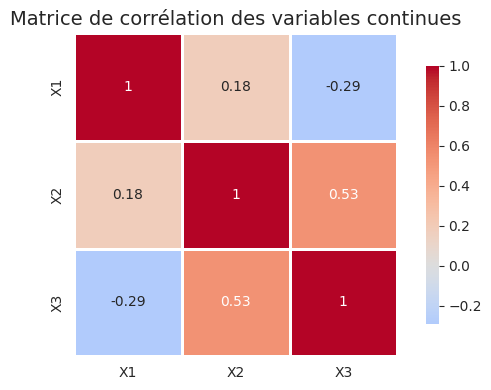


💡 Résumé et recommandations :
  - Les trois variables continues montrent des distributions fortement asymétriques
  - Transformation Yeo-Johnson recommandée pour normaliser les distributions
  - Outliers détectés : 293 au total
  - Corrélations faibles avec la cible, mais potentiellement utiles après transformation


In [ ]:

## 4.2 Analyse statistique des variables quantitatives <a id="analyse-statistique-des-variables-quantitatives"></a>

print("📊 Analyse statistique des variables quantitatives")
print("="*60)

from exploration.statistics import analyze_continuous_variables
#from modules.exploration.statistics import analyze_continuous_variables


# Lancement de l’analyse complète
results_stats = analyze_continuous_variables(
    df=df_study,
    continuous_cols=continuous_cols,
    target_col='y',
    save_figures_path=str(FIGURES_DIR / "eda")  # Assure-toi que ce dossier existe
)



## 4.2.1 Visualisation des distributions et des boxplots <a id="distributions-et-boxplots"></a>

📊 Visualisation des distributions et des boxplots


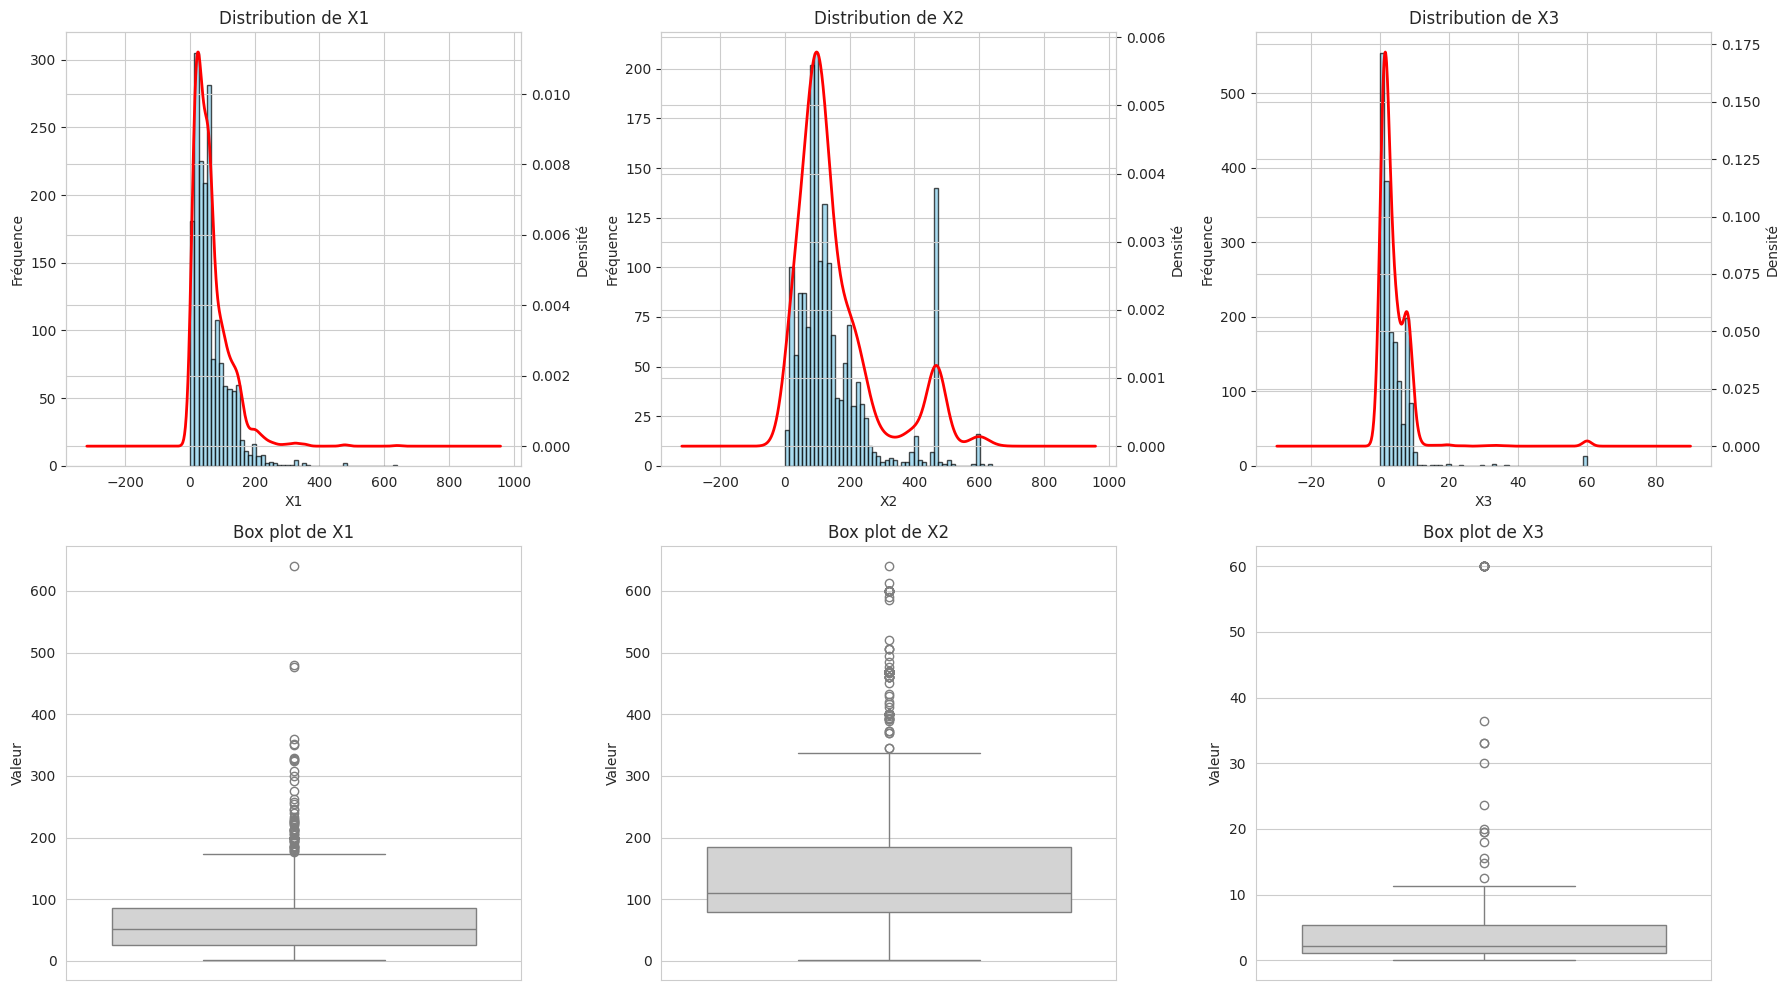

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/eda/continuous_distributions_boxplots.png
✅ Visualisations sauvegardées dans : /content/drive/MyDrive/projet_sta211/outputs/figures/eda/continuous_distributions_boxplots.png


In [ ]:
## 4.2.1 Visualisation des distributions et des boxplots <a id="distributions-et-boxplots"></a>

print("📊 Visualisation des distributions et des boxplots")
print("="*60)

from exploration.visualization import visualize_distributions_and_boxplots
# Appel de la fonction
visualize_distributions_and_boxplots(
    df=df_study,
    continuous_cols=continuous_cols,
    output_dir=FIGURES_DIR / "eda"
)

## 📊 Synthèse de l'analyse statistique

### Variables analysées : X1, X2, X3 (~1780 observations chacune)

**🔍 Principales observations :**
- **Distributions non-normales** : Toutes variables fortement asymétriques (skewness : 1.6 à 7.1)
- **293 outliers** détectés (~16% des données)
- **Corrélations notables** : X2-X3 (r=0.53), X1-X3 (r=-0.29)

**⚠️ Points d'attention :**
- Écart important moyenne/médiane pour toutes variables
- X3 particulièrement problématique (skewness=7.06, kurtosis=63.4)
- Tests de Shapiro-Wilk : p<0.001 (rejet normalité)

**🔄 Actions requises :**
- **Transformation Yeo-Johnson** recommandée avant analyse paramétrique
- Considérer méthodes robustes/non-paramétriques
- Investigation des valeurs aberrantes


## 4.3 Distribution des variables binaires <a id="distribution-des-variables-binaires"></a>


🔢 Analyse de la distribution des variables binaires

📊 Nombre total de variables binaires : 1555

📊 Statistiques des taux de présence :
  - Moyenne : 0.81%
  - Médiane : 0.49%
  - Min : 0.08%
  - Max : 76.98%

📊 Sparsité globale : 99.19% de zéros


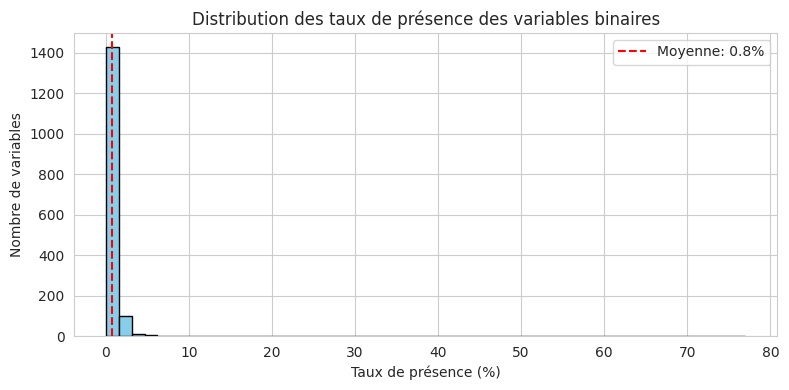

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/eda/binary_presence_distribution.png

✅ Analyse des variables binaires terminée
   → Dataset très sparse, adapté pour des méthodes de sélection de features


In [ ]:
## 4.3 Distribution des variables binaires <a id="distribution-des-variables-binaires"></a>

print("🔢 Analyse de la distribution des variables binaires")
print("="*60)

from exploration.visualization import save_fig

# Variables binaires (exclut les variables continues)
binary_cols = [col for col in df_study.columns if col.startswith('X') and col not in continuous_cols]
print(f"\n📊 Nombre total de variables binaires : {len(binary_cols)}")

# Taux de présence (valeurs à 1)
presence_rates = {
    col: (df_study[col] == 1).sum() / len(df_study) * 100 for col in binary_cols
}
presence_series = pd.Series(presence_rates)

# Statistiques globales
print(f"\n📊 Statistiques des taux de présence :")
print(f"  - Moyenne : {presence_series.mean():.2f}%")
print(f"  - Médiane : {presence_series.median():.2f}%")
print(f"  - Min : {presence_series.min():.2f}%")
print(f"  - Max : {presence_series.max():.2f}%")

# Sparsité globale
total_values = len(df_study) * len(binary_cols)
total_ones = df_study[binary_cols].sum().sum()
sparsity = (1 - total_ones / total_values) * 100
print(f"\n📊 Sparsité globale : {sparsity:.2f}% de zéros")

# Visualisation
plt.figure(figsize=(8, 4))
presence_series.hist(bins=50, color='skyblue', edgecolor='black')
plt.axvline(presence_series.mean(), color='red', linestyle='--', label=f'Moyenne: {presence_series.mean():.1f}%')
plt.xlabel('Taux de présence (%)')
plt.ylabel('Nombre de variables')
plt.title('Distribution des taux de présence des variables binaires')
plt.legend()
plt.tight_layout()

save_fig("binary_presence_distribution.png", directory=FIGURES_DIR / "eda", dpi=300, show=True)

print("\n✅ Analyse des variables binaires terminée")
print("   → Dataset très sparse, adapté pour des méthodes de sélection de features")


## 4.4 Analyse des corrélations combinées <a id="analyse-correlations-combinees"></a>



🔗 Lancement de l'analyse combinée des corrélations (features ↔ cible, features ↔ features)...
## Analyse des corrélations <a id='analyse-des-correlations'></a>

🔗 Analyse des corrélations

📊 Sélection des variables pour l’analyse des corrélations...
  - Variables sélectionnées : 43 (3 continues + 40 binaires)

📊 Calcul de la matrice de corrélation...

🎯 Top 10 corrélations avec la cible (y) :
  - X2: 0.5732
  - X1424: 0.2709
  - X168: 0.2245
  - X1294: 0.2069
  - X664: 0.1736
  - X1009: 0.1662
  - X27: 0.1503
  - X483: 0.1417
  - X1438: 0.1311
  - X3: 0.1301

🎯 Bottom 10 corrélations avec la cible (y) :
  - X363: -0.0305
  - X590: -0.0305
  - X809: -0.0316
  - X69: -0.0326
  - X852: -0.0336
  - X324: -0.0346
  - X1039: -0.0409
  - X1314: -0.0557
  - X265: -0.0575
  - X549: -0.1289


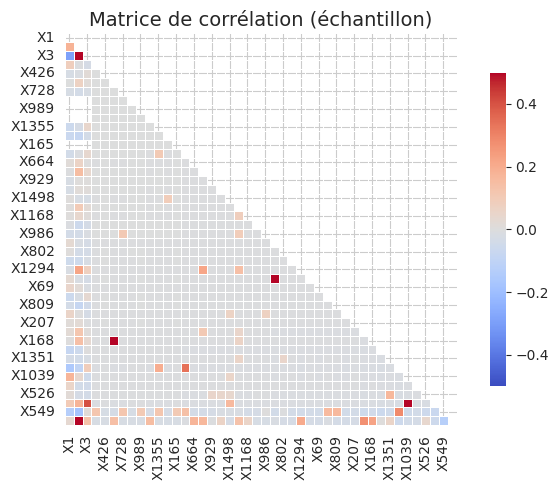

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/eda/correlation_matrix_sample.png

🔍 Analyse des corrélations entre features :
⚠️ Paires de variables très corrélées : 1
  - X909 vs X363: 0.935

## 4.5 Analyse approfondie des corrélations <a id='analyse-approfondie-correlations'></a>

🔗 Analyse approfondie des corrélations entre variables...

=== Analyse Bivariée ===

🔝 Top 20 variables les plus corrélées à la cible :
  feature  correlation
1      X2       0.5732
2      X3       0.1301
0      X1       0.0342

🔢 Variables binaires très corrélées (|r| > 0.95):
  - Nombre total : 3506
  - Moyenne : 0.993
  - Max : 1.000

  Exemples :
    1. X6 ↔ X245: r = 1.000
    2. X6 ↔ X487: r = 1.000
    3. X6 ↔ X596: r = 1.000
    4. X7 ↔ X332: r = 1.000
    5. X7 ↔ X619: r = 1.000


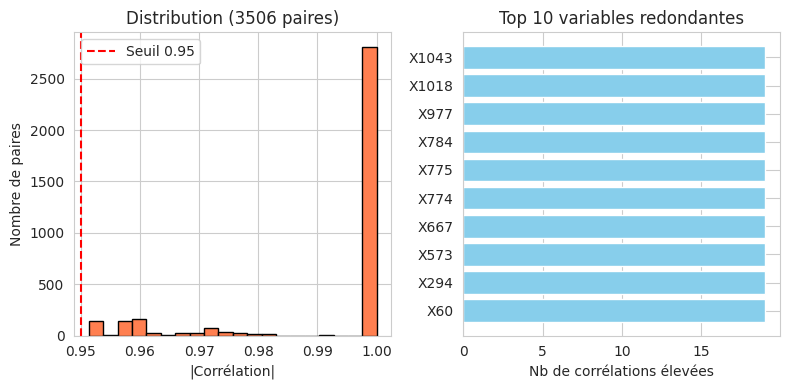

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/eda/binary_correlations_analysis.png

💡 Résumé :
  - Corrélation max avec y : 0.573
  - Dataset sparse avec peu de multicolinéarité
  - Réduction de dimension recommandée (sélection ou PCA)

✅ Résultats sauvegardés dans : /content/drive/MyDrive/projet_sta211/results/bivariate_analysis_results.json


In [ ]:
## 4.4 Analyse des corrélations combinées <a id="analyse-correlations-combinees"></a>

print("🔗 Lancement de l'analyse combinée des corrélations (features ↔ cible, features ↔ features)...")
print("=" * 80)

from exploration.eda_analysis import full_correlation_analysis

# Appel avec paramètres personnalisés
full_correlation_analysis(
    df_study=df_study,
    continuous_cols=continuous_cols,
    presence_rates=presence_rates,
    FIGURES_DIR=FIGURES_DIR,
    ROOT_DIR=ROOT_DIR,
    figsize_corr_matrix=(7, 5),
    figsize_binary=(8, 4)
)

## 📌 Synthèse de l'analyse des corrélations <a id="synthese-correlations"></a>

### 🔍 Corrélations avec la variable cible (`y`)

- ✅ **Meilleure variable prédictive continue** : `X2` avec une corrélation de **0.573**
- 📉 Les autres variables (continues ou binaires) ont une corrélation **faible à modérée** avec `y` (souvent < 0.2)
- ℹ️ Cela suggère que la **modélisation devra combiner plusieurs variables** pour être efficace

---

### 🔗 Corrélations entre variables

- ⚠️ **1 paire** de variables (binaires ou continues) présente une **corrélation > 0.8**
- ✅ **Multicolinéarité faible** → pas de besoin urgent de supprimer des variables continues

---

### Redondance dans les variables binaires

- 📊 **3 506 paires** de variables binaires présentent une corrélation **> 0.95**
- 🔁 Ces paires impliquent **de nombreuses variables dupliquées** ou très similaires
- 🧠 Certaines variables sont impliquées dans **15+ paires corrélées**, suggérant des motifs de duplication

---

### 🧭 Recommandations

- 🧹 Appliquer une **réduction de dimension** avant la modélisation :
  - Suppression de variables binaires fortement redondantes
  - Utilisation de **PCA**, **autoencoders** ou sélection par importance (e.g. **Random Forest**)
- 🎯 Se concentrer sur `X2` et les variables binaires les plus corrélées à `y` comme features de base

---

## 4.6 Visualisations globales de l'EDA <a id="visualisation-globale"></a>


📊 Visualisations exploratoires

📈 Distribution des variables continues par classe...


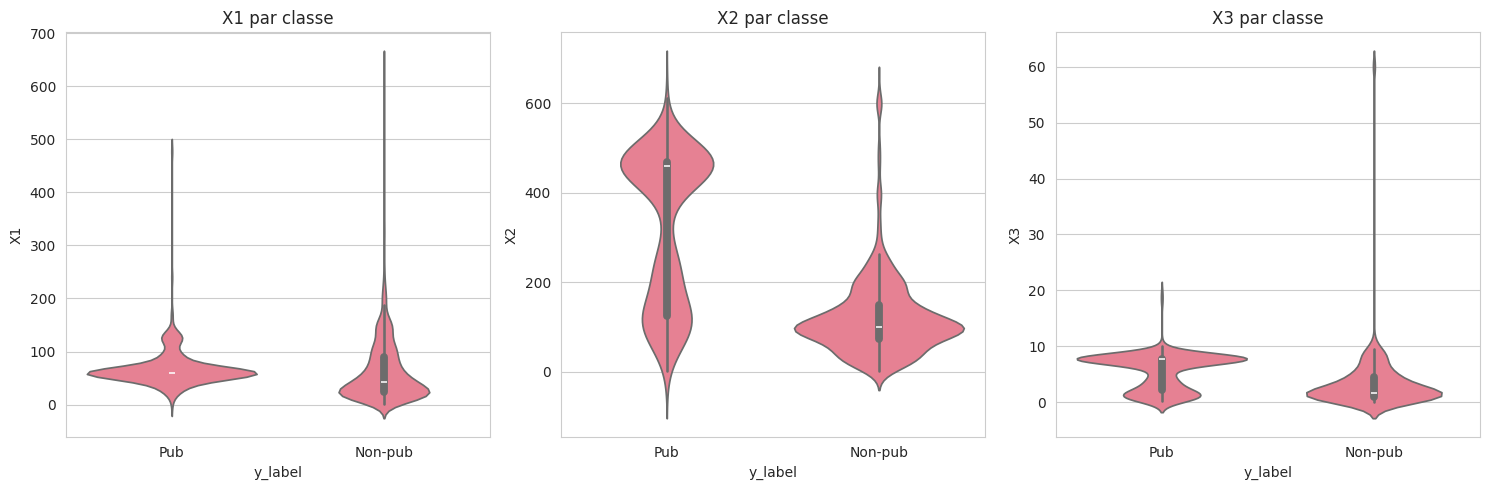

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/eda/continuous_by_class.png

📉 Visualisation de la sparsité des données binaires...


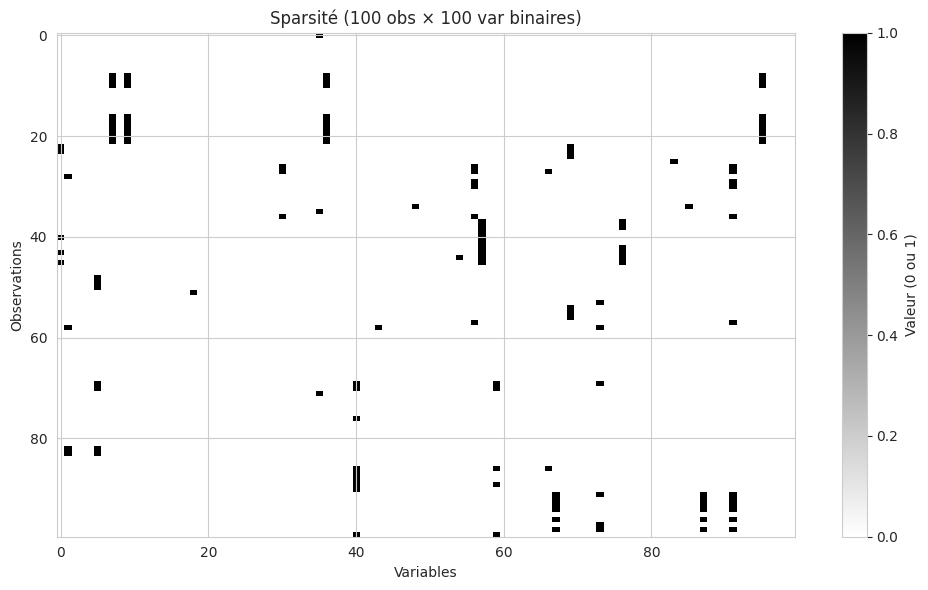

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/eda/sparsity_visualization.png


In [ ]:
## 4.6 Visualisations globales de l'EDA <a id="visualisation-globale"></a>

print("📊 Visualisations exploratoires")
print("=" * 60)

# Imports des fonctions refactorisées
from exploration.visualization import (
    compare_visualization_methods,
    plot_continuous_by_class,
    plot_binary_sparsity,
    plot_continuous_target_corr,
    plot_eda_summary,
    save_fig
)
from exploration.statistics import optimized_feature_importance  # ✅ Nouvelle fonction importée

# 1. Distribution des variables continues par classe
print("\n📈 Distribution des variables continues par classe...")
plot_continuous_by_class(
    df=df_study,
    continuous_cols=continuous_cols,
    output_dir=FIGURES_DIR / 'eda'
)

# 2. Visualisation de la sparsité
print("\n📉 Visualisation de la sparsité des données binaires...")
plot_binary_sparsity(
    df=df_study,
    binary_cols=binary_cols,
    output_dir=FIGURES_DIR / 'eda'
)



🔗 Corrélations des variables continues avec la cible...


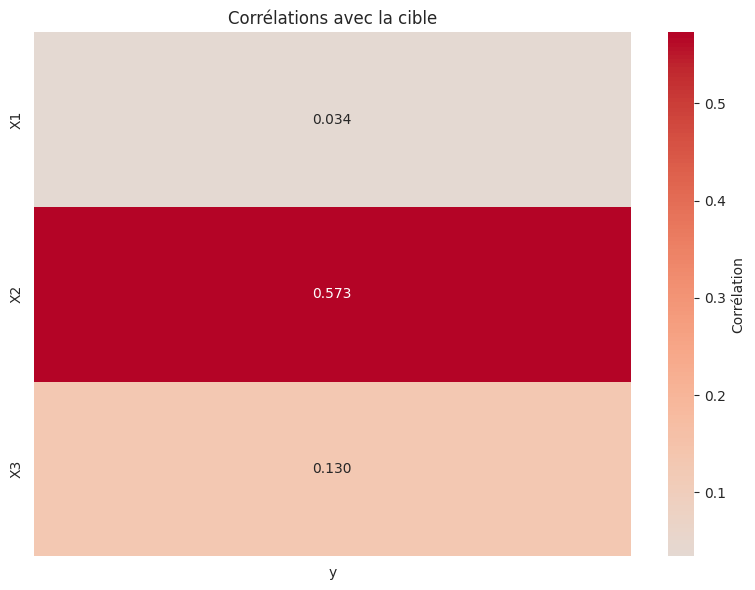

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/eda/continuous_target_correlation.png

📊 Visualisation multidimensionnelle (PCA / t-SNE / UMAP)...


In [ ]:

# 3. Corrélations des variables continues avec la cible
print("\n🔗 Corrélations des variables continues avec la cible...")
plot_continuous_target_corr(
    df=df_study,
    continuous_cols=continuous_cols,
    output_dir=FIGURES_DIR / 'eda'
)

# 4. Réduction de dimension avec UMAP / t-SNE / PCA
print("\n📊 Visualisation multidimensionnelle (PCA / t-SNE / UMAP)...")

df_study_viz = df_study.copy()
df_study_viz['outcome'] = df_study_viz['y'].map({0: 'noad.', 1: 'ad.'})  # ✅ temporaire

# 🔁 Recalcul des corrélations si besoin
target_corr = df_study[continuous_cols + ['y']].corr()['y'].drop('y')

important_features = continuous_cols + list(target_corr.abs().nlargest(30).index)
df_sample = df_study_viz[important_features + ['outcome']].dropna()




🌲 Analyse de l’importance des features...
⚠️ Erreur : The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

📊 Création du résumé visuel de l’EDA...


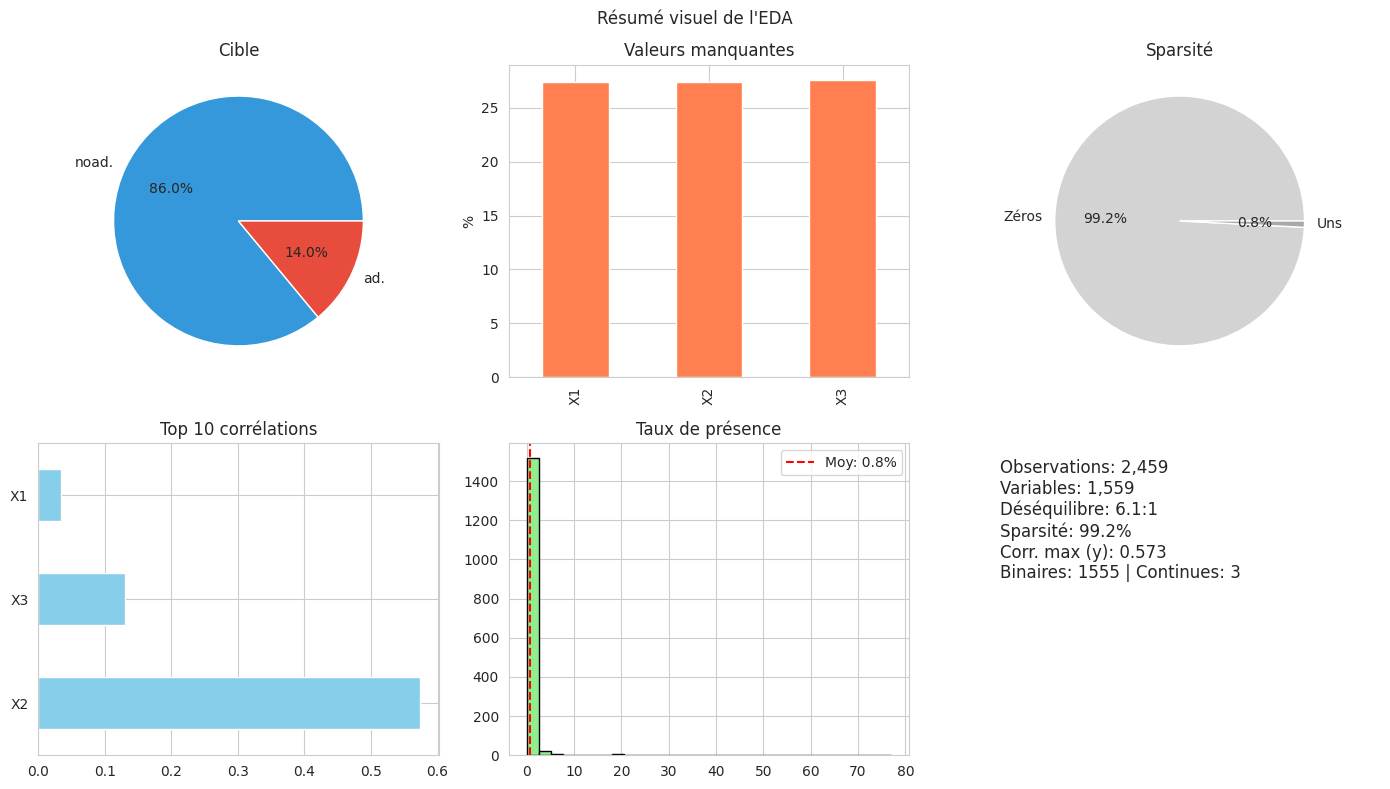

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/eda/eda_summary.png

✅ Visualisations exploratoires terminées avec succès !


In [ ]:

# 5. Importance des variables
print("\n🌲 Analyse de l’importance des features...")
try:
    df_importance = df_sample.copy()  # contient outcome déjà transformée
    importance_results = optimized_feature_importance(
        df=df_importance,
        target_col='outcome',
        method='all',
        top_n=10,
        figsize=(8, 4),
        save_path=FIGURES_DIR / 'eda' / 'feature_importance.png',
        show=True
    )
    if not importance_results.empty:
        print("\nTop 10 features les plus importantes :")
        print(importance_results[['feature', 'Combined_Score']].head(10))
except Exception as e:
    print(f"⚠️ Erreur lors de l’analyse d’importance des features : {e}")

# 6. Résumé visuel global
print("\n📊 Création du résumé visuel de l’EDA...")
plot_eda_summary(
    df=df_study,
    continuous_cols=continuous_cols,
    binary_cols=binary_cols,
    target_corr=target_corr,
    sparsity=sparsity,
    imbalance_ratio=imbalance_ratio,
    output_dir=FIGURES_DIR / 'eda',
    presence_series=presence_series
)

print("\n✅ Visualisations exploratoires terminées avec succès !")

## 🧭 Interprétations synthétiques des résultats de l'EDA <a id="interpretations-eda"></a>

### 🎯 1. Distribution des variables continues par classe
- **X1, X2, X3** présentent des distributions très différentes entre les deux classes (`ad.` vs `noad.`).
- **X2** se distingue particulièrement avec une séparation marquée entre les classes.
- Les distributions sont asymétriques, avec la présence d’**outliers** visibles dans chaque classe.

---

### 🧪 2. Corrélations avec la variable cible
- **X2** est la variable la plus corrélée avec la cible (`corr = 0.573`), ce qui en fait une **feature clé**.
- **X1** (`corr = 0.034`) et **X3** (`corr = 0.130`) ont des corrélations faibles mais non négligeables.
- Cela suggère l’utilité de **modèles non linéaires** ou **ensemble methods** (e.g. Random Forest, Gradient Boosting).

---

### 🧬 3. Visualisation de la sparsité des variables binaires
- Le dataset est **extrêmement sparse**, avec **99.2% de zéros** dans les variables binaires.
- Implications :
  - Risque de surapprentissage élevé si toutes les variables sont conservées.
  - Nécessité de sélection de variables ou de techniques de réduction (PCA, autoencoders).
  - Attention aux méthodes sensibles à la densité (ex : k-NN).

---

### 🗺️ 4. Résumé visuel global
- **Déséquilibre important** : 86% `noad.` vs 14% `ad.` → nécessite des stratégies adaptées :
  - Métriques robustes (F1-score, recall).
  - Rééchantillonnage ou `class_weight='balanced'`.
- **Valeurs manquantes** (~27%) dans X1, X2, X3 : à imputer avec méthode robuste (KNN, MICE).
- **Top corrélations** concentrées sur peu de variables → importance d’une **bonne sélection de features**.

---

### ✅ Recommandations clés
- **Prétraitement renforcé** :
  - Transformation des variables continues (Yeo-Johnson recommandée).
  - Suppression ou gestion des outliers extrêmes.
- **Réduction de dimension** :
  - Visualisation UMAP/t-SNE utile pour vérifier la structure.
  - Sélection de features importante avant modélisation (selon importance ou redondance).
- **Rééquilibrage des classes** indispensable pour éviter un biais fort du modèle vers la classe majoritaire.

---


## 5. Prétraitement avancé <a id="pretraitement-avance"></a>

### 5.1 Transformation Yeo-Johnson sur X1, X2, X3 <a id="transformation-yeo-johnson"></a>

#### 🔁 Transformation des variables continues

Les variables `X1`, `X2` et `X3` présentent une forte asymétrie positive ainsi que des valeurs extrêmes détectées via la règle de l’IQR.

#### 📌 Objectif :
- Stabiliser la variance
- Réduire l’impact des outliers
- Améliorer la distribution pour les modèles sensibles à la normalité (régression logistique, kNN…)

#### ⚙️ Méthode :
Nous utilisons la transformation **Yeo-Johnson** via `PowerTransformer`, qui accepte les valeurs nulles ou strictement positives.

> 🔧 Les colonnes transformées seront ajoutées en tant que `X1_trans`, `X2_trans` et `X3_trans`.


In [ ]:
from preprocessing.final_preprocessing import apply_yeojohnson

# Appliquer Yeo-Johnson aux variables continues
df_study = apply_yeojohnson(
    df=df_study,
    columns=["X1", "X2", "X3"],
    standardize=False,
    save_model=True,
    model_path=MODELS_DIR / "yeojohnson_transformer.pkl"
)

# Vérification visuelle rapide des variables transformées
df_study[["X1_trans", "X2_trans", "X3_trans"]].describe()




✅ Transformateur Yeo-Johnson sauvegardé à : /content/drive/MyDrive/projet_sta211/models/yeojohnson_transformer.pkl


,X1_trans,X2_trans,X3_trans
count,1785.0000,1786.0000,1780.0000
mean,4.1962,7.0209,0.8632
std,0.9362,1.6675,0.2828
min,0.7029,0.7306,0.0015
25%,3.4817,6.2312,0.5833
50%,4.2833,6.8568,0.8343
75%,4.8793,7.9452,1.1282
max,7.3831,10.9369,1.5537


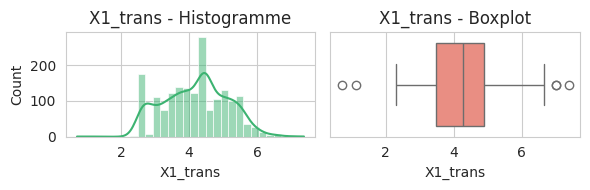

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/preprocessing/X1_trans_distribution_boxplot.png


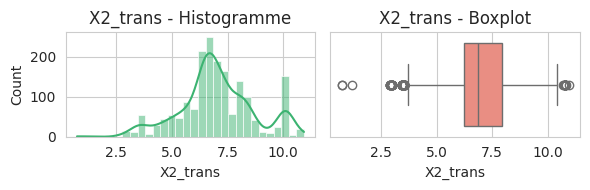

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/preprocessing/X2_trans_distribution_boxplot.png


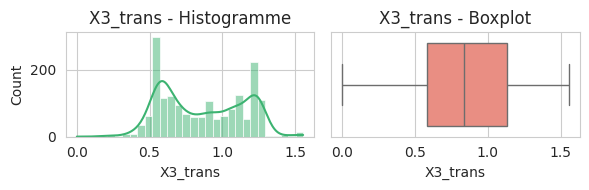

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/preprocessing/X3_trans_distribution_boxplot.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ✅ Liste des variables transformées
transformed_vars = ["X1_trans", "X2_trans", "X3_trans"]

# 📁 Dossier de sauvegarde
output_dir = FIGURES_DIR / 'preprocessing'
output_dir.mkdir(parents=True, exist_ok=True)

# 🔁 Génération et sauvegarde des figures
for col in transformed_vars:
    fig, ax = plt.subplots(1, 2, figsize=(6, 2))

    # Histogramme + KDE
    sns.histplot(df_study[col], bins=30, kde=True, ax=ax[0], color="mediumseagreen")
    ax[0].set_title(f"{col} - Histogramme")
    ax[0].set_xlabel(col)

    # Boxplot
    sns.boxplot(x=df_study[col], ax=ax[1], color="salmon")
    ax[1].set_title(f"{col} - Boxplot")

    plt.tight_layout()

    # 💾 Sauvegarde
    fig_path = output_dir / f"{col}_distribution_boxplot.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Figure sauvegardée : {fig_path}")


## 🔁 Transformation Yeo-Johnson des variables continues <a id="yeojohnson-interprétation"></a>

### Résultats visuels

Les histogrammes et boxplots suivants montrent l'effet de la transformation Yeo-Johnson sur les variables `X1`, `X2` et `X3` :

- ✅ **Meilleure symétrie** des distributions.
- ✅ **Réduction de l'effet des outliers** (même si certains persistent, notamment sur `X2`).
- ✅ **Concentration des valeurs** autour de la médiane, utile pour les modèles sensibles aux échelles et à la normalité.

---

### Interprétation

| Variable   | Résultat après transformation                             | Commentaire                                                                 |
|------------|------------------------------------------------------------|------------------------------------------------------------------------------|
| `X1_trans` | Distribution plus centrée et symétrique                   | Forte amélioration visuelle, outliers encore présents mais moins extrêmes   |
| `X2_trans` | Distribution toujours multimodale avec quelques extrêmes  | Transformation partiellement efficace – normalisation partielle             |
| `X3_trans` | Distribution globalement normalisée                       | Très bon résultat – faible asymétrie et étendue réduite                     |

---

### 📌 Conclusion

- La transformation **Yeo-Johnson** est efficace pour réduire l'asymétrie des variables `X1`, `X2` et `X3`.
- Elle **prépare les données à des modèles linéaires** ou sensibles aux distances (kNN, régression).
- Un **traitement complémentaire des outliers** peut être envisagé, surtout pour `X2`.


## 5.2 Détection et suppression des outliers <a id="detection-et-suppression-des-outliers"></a>

### 🎯 Objectifs :
- Identifier les observations extrêmes susceptibles de perturber la modélisation.
- Appliquer une stratégie de suppression uniquement sur les variables continues (`X1`, `X2`, `X3`), après transformation.

### 🛠️ Méthode :
- Utilisation de la règle de l’IQR (Interquartile Range).
- Application sur les colonnes transformées : `X1_trans`, `X2_trans`, `X3_trans`.
- Suppression des lignes contenant au moins un outlier dans ces colonnes.

### 📉 Impact attendu :
- Réduction de l’effet des valeurs extrêmes sur les modèles sensibles.
- Meilleure normalité après transformation.
- Perte contrôlée d’observations (généralement < 5%).

### ✅ Étapes suivantes :
1. Détection via IQR (Q1 - 1.5×IQR, Q3 + 1.5×IQR)
2. Comptage des lignes extrêmes par variable
3. Suppression des lignes avec outliers dans au moins une variable
4. Affichage du pourcentage de données supprimées

> 🔍 Cette étape ne sera appliquée que sur `df_study` (jeu d'entraînement).


In [ ]:
## 5.2 Détection et suppression des outliers <a id="detection-et-suppression-des-outliers"></a>

print("🔍 Détection et suppression des outliers (méthode IQR)")
print("=" * 60)

from preprocessing.outliers import detect_and_remove_outliers

# ✅ Variables à traiter (transformées)
transformed_cols = ["X1_trans", "X2_trans", "X3_trans"]

# ✅ Sauvegarde de la version avant suppression
df_with_outliers = df_study.copy()

# ✅ Chemin de sauvegarde après nettoyage
output_path = OUTPUTS_DIR / "data" / "df_after_outliers.csv"

# ✅ Suppression des outliers avec export CSV
df_study = detect_and_remove_outliers(
    df=df_study,
    columns=transformed_cols,
    method='iqr',
    iqr_multiplier=1.5,
    verbose=True,
    save_path=output_path
)

# ✅ Aperçu statistique post-nettoyage
print("\n📊 Statistiques descriptives après suppression des outliers :")
display(df_study[transformed_cols].describe())





🔍 Détection et suppression des outliers (méthode IQR)
📉 X1_trans : 679 outliers détectés
📉 X2_trans : 768 outliers détectés
📉 X3_trans : 679 outliers détectés

✅ Nombre total de lignes supprimées : 775
🔢 Nouvelle taille du dataset : (1684, 1562)
💾 Données sauvegardées à : /content/drive/MyDrive/projet_sta211/outputs/data/df_after_outliers.csv

📊 Statistiques descriptives après suppression des outliers :


,X1_trans,X2_trans,X3_trans
count,1684.0000,1684.0000,1684.0000
mean,4.2558,7.1481,0.8723
std,0.8980,1.4600,0.2722
min,2.2975,3.7058,0.2166
25%,3.6065,6.4151,0.6079
50%,4.3704,6.9289,0.8639
75%,4.9470,7.9891,1.1282
max,6.6431,10.3966,1.5026


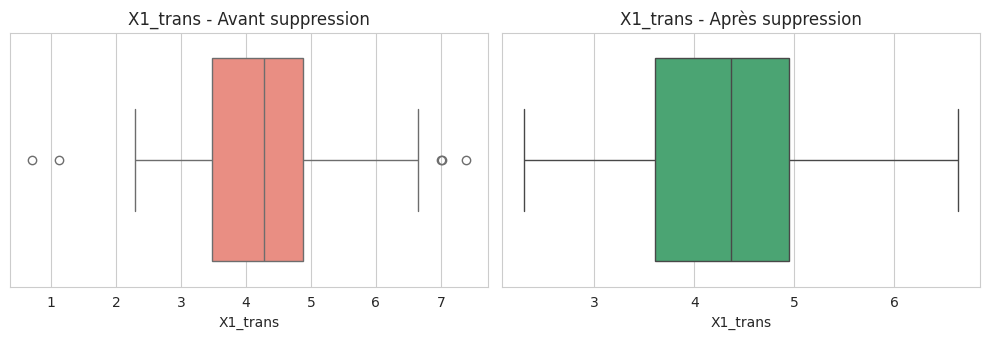

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/eda/X1_trans_outliers_comparison.png


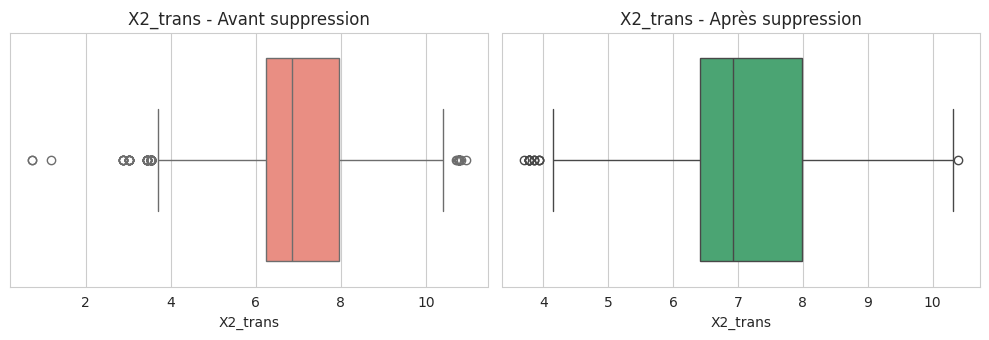

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/eda/X2_trans_outliers_comparison.png


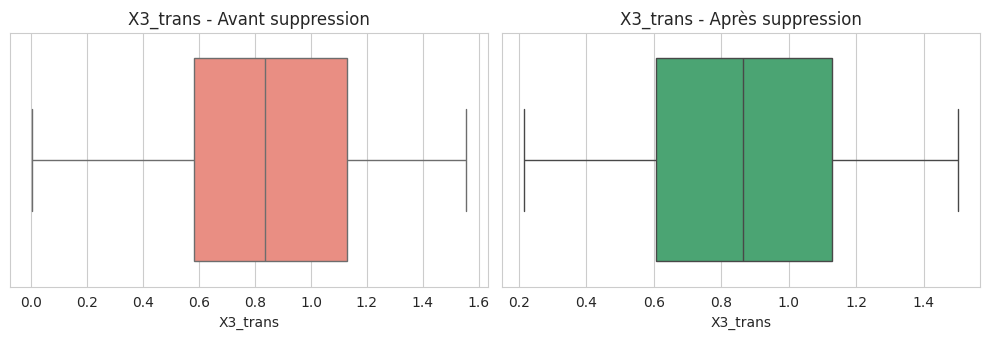

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/eda/X3_trans_outliers_comparison.png


In [ ]:

## 📊 Visualisation comparative avant/après suppression des outliers

from exploration.visualization import plot_outlier_comparison

# ✅ Comparaison visuelle avant / après (X1_trans, X2_trans, X3_trans)
plot_outlier_comparison(
    df_before=df_with_outliers,
    df_after=df_study,
    cols=transformed_cols,
    output_dir=FIGURES_DIR / "eda",
    show=True
)





## 📉 Analyse des effets de la suppression des outliers <a id="effet-suppression-outliers"></a>

### Objectif :
La détection des outliers est effectuée sur les variables transformées (`X1_trans`, `X2_trans`, `X3_trans`) via la méthode de l’IQR (Interquartile Range), afin de réduire l’influence des valeurs extrêmes sur les modèles.

---

### 🔍 Résultats :

#### ✅ **X1_trans**
- **Avant** : présence de plusieurs outliers extrêmes à gauche et à droite.
- **Après** : distribution recentrée, disparition des extrêmes anormaux.
- **Effet attendu** : meilleure stabilité pour les modèles linéaires sensibles à la variance.

#### ✅ **X2_trans**
- **Avant** : distribution asymétrique avec une concentration importante d’outliers à gauche (valeurs faibles).
- **Après** : distribution plus compacte, réduction de l’asymétrie, moins d’observations extrêmes.
- **Effet attendu** : amélioration de la normalité et du comportement statistique de la variable.

#### ✅ **X3_trans**
- **Avant** : très peu d’outliers détectés, distribution relativement homogène.
- **Après** : suppression minimale, confirmant que X3_trans était déjà bien normalisée.
- **Effet attendu** : impact marginal, mais bénéfique pour les modèles robustes.

---

### 🎯 Conclusion :
- La suppression des outliers permet d’obtenir des distributions plus resserrées et symétriques.
- Elle améliore la qualité des données, tout en préservant la majorité des observations informatives.
- Deux versions du dataset sont conservées :
  - **Avec outliers** : pour tester la robustesse des modèles.
  - **Sans outliers** : pour évaluer les gains en stabilité et performance.


## 5.3 Gestion des valeurs manquantes <a id="gestion-des-valeurs-manquantes"></a>

La gestion des valeurs manquantes est cruciale pour garantir la qualité des analyses et des modèles.

### 🔎 Objectifs :
- Imputer intelligemment les valeurs manquantes
- Préserver la structure statistique du dataset
- Minimiser la distorsion induite par les imputations

### ⚙️ Méthodologie adoptée :
- Analyse de la structure des valeurs manquantes (`MCAR`, `MAR`)
- Imputation simple (médiane) pour certaines variables
- Imputation multiple (MICE ou KNN) pour les autres
- Sauvegarde des jeux de données imputés pour modélisation


### ✅ 5.3.1 Imputation de X4 par la médiane <a id="imputation-x4-mediane"></a>

La variable `X4`, de type discrète (0/1), a été imputée **précocement par la médiane**, ce qui est adapté à une variable binaire avec peu de valeurs manquantes.  
→ Aucun traitement supplémentaire n’est nécessaire ici.

---

### 🚧 Prochaine étape : **imputation multiple** sur les variables continues `X1`, `X2`, `X3` via des méthodes plus robustes (KNN ou MICE).


### 5.3.2 Préparation pour l'imputation multivariée <a id="preparation-imputation-multivariee"></a>

🔧 Préparation à l'imputation multiple (KNN / MICE)

📊 Analyse (données avec outliers)
Total missing       : 2026 (27.46%)
Colonnes affectées  : 3 (haut: 0, moyen: 3, bas: 0)
Top 5 colonnes manquantes :
X3_trans   27.6129
X1_trans   27.4095
X2_trans   27.3688
dtype: float64


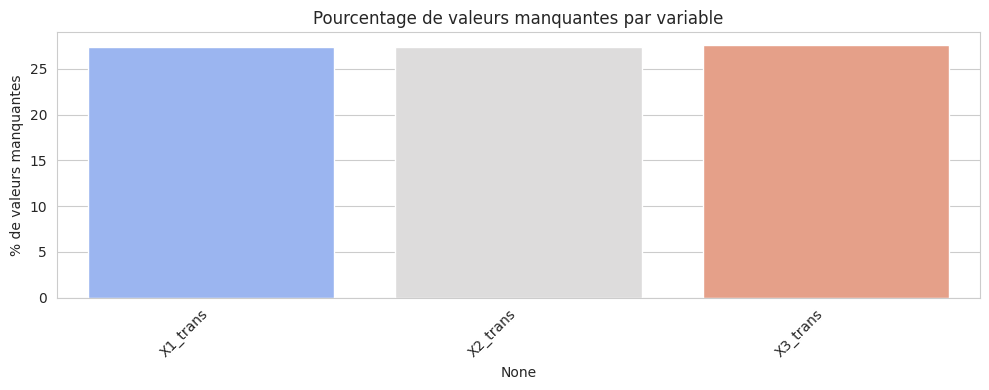


📌 Colonnes retenues (avec outliers) :
['X1_trans', 'X2_trans', 'X3_trans']

📊 Analyse (données sans outliers)
Total missing       : 0 (0.00%)
Colonnes affectées  : 0 (haut: 0, moyen: 0, bas: 0)
Top 5 colonnes manquantes :
Series([], dtype: float64)

📌 Colonnes retenues (sans outliers) :
['X1_trans', 'X2_trans', 'X3_trans']


In [22]:
## 5.3.2 Préparation pour l'imputation multivariée <a id="preparation-imputation-multivariee"></a>

print("🔧 Préparation à l'imputation multiple (KNN / MICE)")
print("=" * 60)

from preprocessing.missing_values import analyze_missing_values

cols_to_check = ["X1_trans", "X2_trans", "X3_trans"]

# 📁 Analyse sur les données AVEC outliers
print("\n📊 Analyse (données avec outliers)")
analyze_missing_values(df=df_with_outliers, columns=cols_to_check, plot=True)

# ✅ Colonnes à imputer (si moins de 30 % de valeurs manquantes)
cols_impute_with_outliers = [col for col in cols_to_check
                             if df_with_outliers[col].isna().mean() < 0.30]

print("\n📌 Colonnes retenues (avec outliers) :")
print(cols_impute_with_outliers)


# 📁 Analyse sur les données SANS outliers
print("\n📊 Analyse (données sans outliers)")
analyze_missing_values(df=df_study, columns=cols_to_check, plot=True)

cols_impute_no_outliers = [col for col in cols_to_check
                           if df_study[col].isna().mean() < 0.30]

print("\n📌 Colonnes retenues (sans outliers) :")
print(cols_impute_no_outliers)



## 5.4 Détection et traitement des variables collinéaires <a id="detection-et-traitement-des-variables-collineaires"></a>

# 6. Construction des datasets finaux <a id="construction-des-datasets-finaux"></a>
## 6.1 Application du pipeline de prétraitement (KNN) <a id="pipeline-knn"></a>

## 6.2 Application du pipeline de prétraitement (MICE) <a id="pipeline-mice"></a>

## 6.3 Comparaison des méthodes d'imputation <a id="comparaison-methodes"></a>

## 6.4 Génération des fichiers pour la modélisation <a id="generation-des-fichiers-pour-la-modelisation"></a>

# 7. Validation du prétraitement <a id="validation-pretraitement"></a>
## 7.1 Vérification de la qualité des données <a id="verification-qualite"></a>

## 7.2 Statistiques finales <a id="statistiques-finales"></a>

# 8. Conclusion <a id="conclusion"></a>

# 9. Annexes / Visualisations complémentaires <a id="annexes"></a>